In [1]:
import os
os.chdir('siesta_1')
import numpy as np
from sisl import *
import matplotlib.pyplot as plt
%matplotlib inline

# Siesta --- the H2O molecule

This tutorial will describe a complete walk-through of some of the `sisl` functionalities that may be related to the [Siesta code](https://gitlab.com/siesta-project/siesta).

## Creating the geometry

Our system of interest will be the $\mathrm H_2\mathrm O$ system. The first task will be to create the molecule geometry.
This is done using lists of atomic coordinates and atomic species. Additionally one needs to define the supercell (or if you prefer: unit-cell) where the molecule resides in. Siesta is a periodic DFT code and thus all directions are periodic. I.e. when simulating molecules it is vital to have a large vacuum gap between periodic images. In this case we use a supercell of side-lengths $10\mathrm{Ang}$.

In [2]:
h2o = Geometry([[0, 0, 0], [0.8, 0.6, 0], [-0.8, 0.6, 0.]], 
               [Atom('O'), Atom('H'), Atom('H')], 
               sc=SuperCell(10, origo=[-5] * 3))

The input are the 1) xyz coordinates, 2) the atomic species and 3) the supercell that is attached.

By printing the object one gets basic information regarding the geometry, such as 1) number of atoms, 2) species of atoms, 3) number of orbitals, 4) orbitals associated with each atom and 5) number of supercells.

In [3]:
print(h2o)

Geometry{na: 3, no: 3,
 Atoms{species: 2,
  Atom{O, Z: 8, mass(au): 15.99940, maxR: -1.00000,
   Orbital{R: -1.00000, q0: 0.0}
  }: 1,
  Atom{H, Z: 1, mass(au): 1.00794, maxR: -1.00000,
   Orbital{R: -1.00000, q0: 0.0}
  }: 2,
 },
 maxR: -1.00000,
 SuperCell{nsc: [1 1 1],
  A=[10.000, 0.000, 0.000],
  B=[0.000, 10.000, 0.000],
  C=[0.000, 0.000, 10.000],
 }
}


So there are 3 atoms, 1 Oxygen and 2 Hydrogen. Currently there are only 1 orbital per atom.  
Later we will look into the details of *orbitals* associated with *atoms* and how they may be used for wavefunctions etc.

Lets visualize the atomic positions (here adding atomic indices)

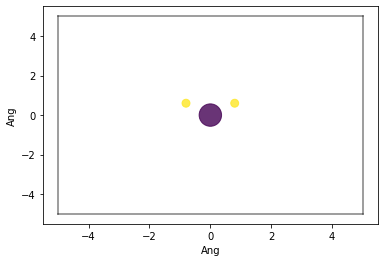

In [4]:
plot(h2o)

Now we need to create the input fdf file for Siesta:

In [5]:
open('RUN.fdf', 'w').write("""%include STRUCT.fdf
SystemLabel siesta_1
PAO.BasisSize SZP
MeshCutoff 250. Ry
CDF.Save true
CDF.Compress 9
SaveHS true
SaveRho true
""")
h2o.write('STRUCT.fdf')

The first block of code simply writes a text-file with the required input, the last line of code tells the geometry (`h2o`) to write its information to the file `STRUCT.fdf`.  
It automatically writes the following geometry information to the fdf file:
- `LatticeConstant`
- `LatticeVectors`
- `NumberOfAtoms`
- `AtomicCoordinatesFormat`
- `AtomicCoordinatesAndAtomicSpecies`
- `NumberOfSpecies`
- `ChemicalSpeciesLabel`

## Creating the electronic structure

Before continuing we need to run Siesta to calculate the electronic structure.
```bash
siesta RUN.fdf
```
After having completed the Siesta run we may read the Siesta output to manipulate and extract different information.

In [6]:
fdf = get_sile('RUN.fdf')
H = fdf.read_hamiltonian()
# Create a short-hand to handle the geometry
h2o = H.geometry
print(H)

Hamiltonian{non-zero: 289, orthogonal: False,
 Spin{unpolarized, kind=f},
 Geometry{na: 3, no: 17,
  Atoms{species: 2,
   Atom{O, Z: 8, mass(au): 16.00000, maxR: 2.08350,
    AtomicOrbital{2sZ1, q0: 2.0, SphericalOrbital{l: 0, R: 1.749, q0: 2.0}},
    AtomicOrbital{2pyZ1, q0: 1.3333333333333333, SphericalOrbital{l: 1, R: 2.0835000000000004, q0: 4.0}},
    AtomicOrbital{2pzZ1, q0: 1.3333333333333333, SphericalOrbital{l: 1, R: 2.0835000000000004, q0: 4.0}},
    AtomicOrbital{2pxZ1, q0: 1.3333333333333333, SphericalOrbital{l: 1, R: 2.0835000000000004, q0: 4.0}},
    AtomicOrbital{2dxyZ1P, q0: 0.0, SphericalOrbital{l: 2, R: 2.0835000000000004, q0: 0.0}},
    AtomicOrbital{2dyzZ1P, q0: 0.0, SphericalOrbital{l: 2, R: 2.0835000000000004, q0: 0.0}},
    AtomicOrbital{2dz2Z1P, q0: 0.0, SphericalOrbital{l: 2, R: 2.0835000000000004, q0: 0.0}},
    AtomicOrbital{2dxzZ1P, q0: 0.0, SphericalOrbital{l: 2, R: 2.0835000000000004, q0: 0.0}},
    AtomicOrbital{2dx2-y2Z1P, q0: 0.0, SphericalOrbital{l: 2, 

A lot of new information has appeared. The Hamiltonian object describes the non-orthogonal basis and the "hopping" elements between the orbitals. We see it is a non-orthogonal basis via: `orthogonal: False`. Secondly, we see it was an un-polarized calculation (`Spin{unpolarized...`).  
Lastly the geometry information is printed again. Contrary to the previous printing of the geometry we now find additional information based on the orbitals on each of the atoms. This information is read from the Siesta output and thus the basic information regarding the orbital symmetry and the basis functions are now handled by `sisl`. The oxygen has 9 orbitals ($s+p+d$ where the $d$ orbitals are $p$-polarizations denoted by capital `P`). We also see that it is a single-$\zeta$ calculation `Z1` (for double-$\zeta$ `Z2` would also appear in the list). The hydrogens only has 4 orbitals $s+p$.
For each orbital one can see its maximal radial part and how initial charges are distributed.

### Plotting orbitals

Often it may be educational (and fun) to plot the orbital wavefunctions. To do this we use the intrinsic method in the `Orbital` class named `toGrid`. The below code is rather complicated, but the complexity is simply because we want to show the orbitals in a rectangular grid of plots.

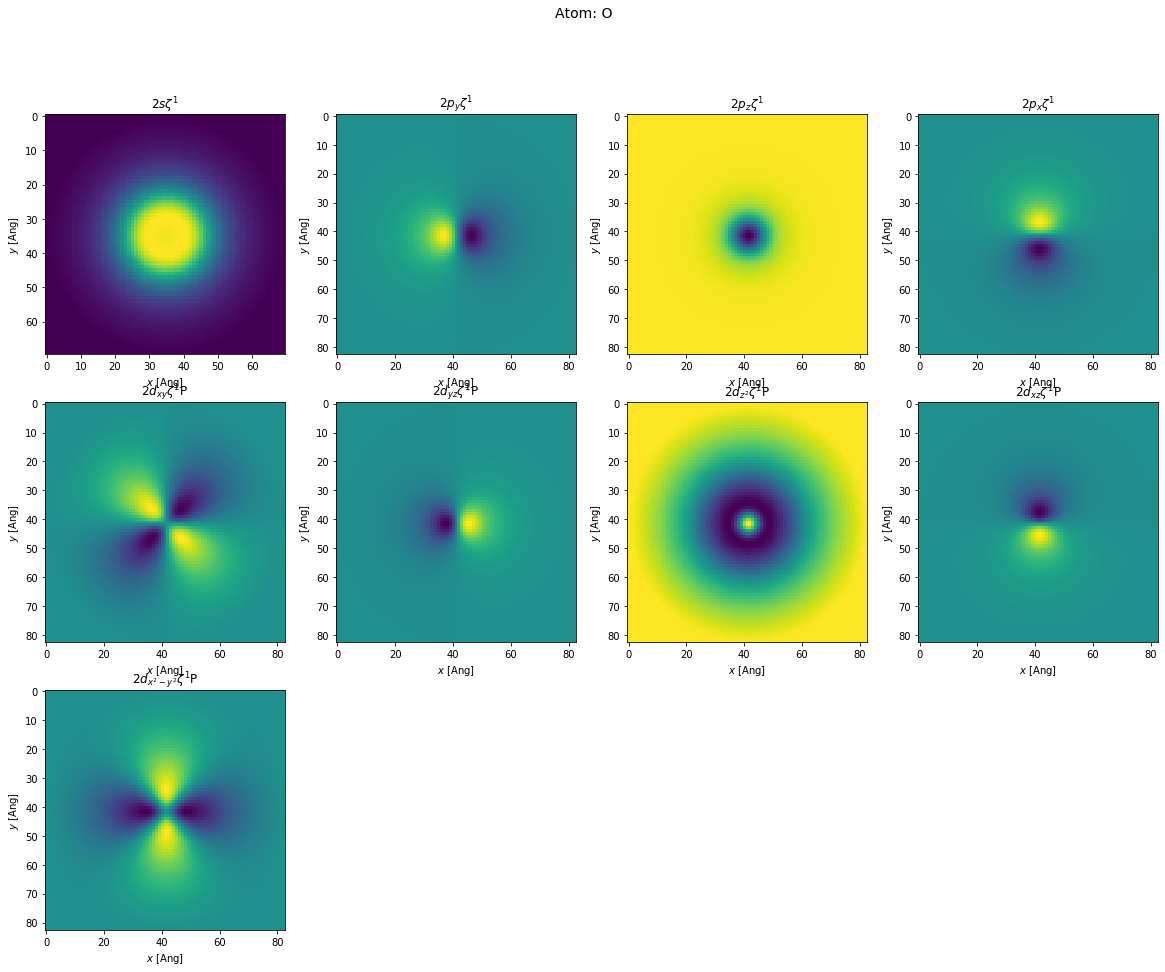

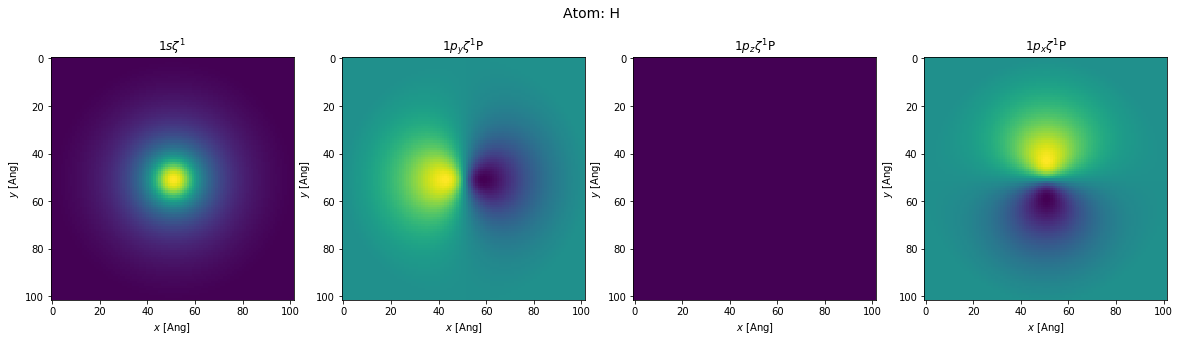

In [7]:
def plot_atom(atom):
    no = len(atom) # number of orbitals
    nx = no // 4
    ny = no // nx
    if nx * ny < no:
        nx += 1
    fig, axs = plt.subplots(nx, ny, figsize=(20, 5*nx))
    fig.suptitle('Atom: {}'.format(atom.symbol), fontsize=14)
    def my_plot(i, orb):
        grid = orb.toGrid(Z=atom.Z)
        # Also write to a cube file
        grid.write('{}_{}.cube'.format(atom.symbol, orb.name()))
        c, r = i // 4, (i - 4) % 4
        if nx == 1:
            ax = axs[r]
        else:
            ax = axs[c][r]
        ax.imshow(grid.grid[:, :, grid.shape[2] // 2])
        ax.set_title(r'${}$'.format(orb.name(True)))
        ax.set_xlabel(r'$x$ [Ang]')
        ax.set_ylabel(r'$y$ [Ang]')
    i = 0
    for orb in atom:
        my_plot(i, orb)
        i += 1
    if i < nx * ny:
        # This removes the empty plots
        for j in range(i, nx * ny):
            c, r = j // 4, (j - 4) % 4
            if nx == 1:
                ax = axs[r]
            else:
                ax = axs[c][r]
            fig.delaxes(ax)
        plt.draw()
plot_atom(h2o.atoms[0])
plot_atom(h2o.atoms[1])

## Hamiltonian eigenstates

At this point we have the full Hamiltonian as well as the basis functions used in the Siesta calculation.
This completes what is needed to calculate a great deal of physical quantities, e.g. eigenstates, density of states, projected density of states and wavefunctions.

To begin with we calculate the $\Gamma$-point eigenstates and plot a subset of the eigenstates' norm on the geometry. An important aspect of the electronic structure handled by Siesta is that it is shifted to $E_F=0$ meaning that the HOMO level is the smallest negative eigenvalue, while the LUMO is the smallest positive eigenvalue:

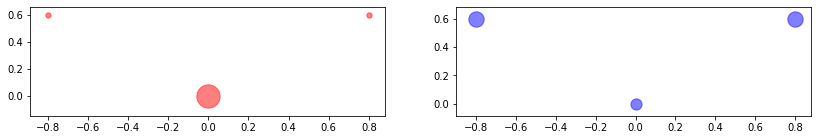

In [8]:
es = H.eigenstate()

# We specify an origo to center the molecule in the grid
h2o.sc.origo = [-4, -4, -4]

# Reduce the contained eigenstates to only the HOMO and LUMO
# Find the index of the smallest positive eigenvalue
idx_lumo = (es.eig > 0).nonzero()[0][0]
es = es.sub([idx_lumo - 1, idx_lumo])
_, ax = plt.subplots(1, 2, figsize=(14, 2));
for i, (norm2, color) in enumerate(zip(es.norm2(sum=False), 'rbg')):
    for ia in h2o:
        ax[i].scatter(h2o.xyz[ia, 0], h2o.xyz[ia, 1], 600 * norm2[h2o.a2o(ia, True)].sum(), facecolor=color, alpha=0.5);

These are not that interesting. The projection of the HOMO and LUMO states show where the largest weight of the HOMO and LUMO states, however we can't see the orbital symmetry differences between the HOMO and LUMO states.

Instead of plotting the weight on each orbital it is more interesting to plot the actual wavefunctions which contains the orbital symmetries, however, matplotlib is currently not capable of plotting real-space iso-surface plots. To do this, please use VMD or your preferred software.

In [9]:
def integrate(g):
    print('Real space integrated wavefunction: {:.4f}'.format((np.absolute(g.grid) ** 2).sum() * g.dvolume))
g = Grid(0.2, sc=h2o.sc)
es.sub(0).wavefunction(g)
integrate(g)
#g.write('HOMO.cube')
g.fill(0) # reset the grid values to 0
es.sub(1).wavefunction(g)
integrate(g)
#g.write('LUMO.cube')

Real space integrated wavefunction: 0.9143
Real space integrated wavefunction: 0.7224


## Real space charge

Since we have the basis functions we can also plot the charge in the grid. We can do this via either reading the density matrix or read in the charge output directly from Siesta.
Since both should yield the same value we can compare the output from Siesta with that calculated in `sisl`.

You will notice that re-creating the density on a real space grid in sisl is much slower than creating the wavefunction. This is because we need _orbital multiplications_.

In [10]:
DM = fdf.read_density_matrix()
rho = get_sile('siesta_1.nc').read_grid('Rho')

In [11]:
DM_rho = rho.copy()
DM_rho.fill(0)
DM.density(DM_rho)
diff = DM_rho - rho
print('Real space integrated density difference: {:.3e}'.format(diff.grid.sum() * diff.dvolume))

Real space integrated density difference: 2.386e-09
